<a href="https://colab.research.google.com/github/EliasCai/rca_visualization/blob/main/RCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install fpgrowth_py
# !pip install pyfpgrowth
# !pip install apriori_python
!pip install -q efficient-apriori
!pip install -q pyvis

In [11]:
import pandas as pd
import time
from datetime import datetime
# from fpgrowth_py import fpgrowth
# import pyfpgrowth
from efficient_apriori import apriori
from pyvis import network as net
from pyvis.network import Network
from IPython.core.display import display, HTML
import numpy as np
import matplotlib


%matplotlib inline

PATH = './省局4-创意赛-信息化基础设施环境下的大规模告警分析-全量数据.csv'
data = pd.read_csv(PATH)
# data['eventTime'] = data.eventTime.map(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(int(x // 1000))))
data['eventTime'] = data.eventTime.map(lambda x: datetime.fromtimestamp(int(x // 1000)))
data['eventTime'] = pd.to_datetime(data['eventTime'])

data['updateTime'] = data.updateTime.map(lambda x: datetime.fromtimestamp(int(x // 1000)))
data['updateTime'] = pd.to_datetime(data['updateTime'])

data['updateDiff'] = data['updateTime'] - data['eventTime']
data['updateDiff'] = data['updateDiff'].dt.seconds
# dd = data.eventTime.map(lambda x: time.strftime("%m-%d", time.localtime(int(x // 1000))))
data.head()

,eventId,eventHost,eventSeverity,eventContent,eventTime,updateTime,eventType,serviceName,updateDiff
0,20623129,server223,minor,Host 10.3.0.2() Interface(utp ethernet (10/100...,2021-02-24 16:01:47,2021-02-24 16:02:59,resolved,hardware,72
1,20623309,server223,minor,Host 10.3.0.3() Interface(utp ethernet (10/100...,2021-02-24 16:11:47,2021-02-24 16:19:29,resolved,hardware,462
2,20623468,server223,minor,Host 10.3.0.3() Interface(utp ethernet (10/100...,2021-02-24 16:27:47,2021-02-24 16:34:59,resolved,hardware,432
3,20623467,server223,minor,Host 10.3.0.2() Interface(utp ethernet (10/100...,2021-02-24 16:33:47,2021-02-24 16:34:59,resolved,hardware,72
4,20623573,server223,minor,Host 10.3.0.3() Interface(utp ethernet (10/100...,2021-02-24 16:40:47,2021-02-24 16:44:17,resolved,hardware,210


In [ ]:
data[data.serviceName == 'computeService']['eventContent'].unique()

array(['The average per-second rate of errors in computeService logs on the server203 node is 1.3606359894001765 (as measured over the last 5 minutes).',
       'The average per-second rate of errors in computeService logs on the server204 node is 1.3575466666666667 (as measured over the last 5 minutes).',
       'The average per-second rate of errors in computeService logs on the server205 node is 1.3338933333333334 (as measured over the last 5 minutes).',
       ...,
       'The average per-second rate of errors in computeService logs on the server125 node is 0.476147684981997 (as measured over the last 5 minutes).',
       'The average per-second rate of errors in computeService logs on the server128 node is 0.41636869941056537 (as measured over the last 5 minutes).',
       'The average per-second rate of errors in computeService logs on the server203 node is 0.22861429473539963 (as measured over the last 5 minutes).'],
      dtype=object)

In [ ]:
import re
s = 'The networkService-agent-2 agent on the server01 node is down.'
# data.head()['eventContent'].map(lambda x: re.serach)

def extracthost(s):

    if re.search('server[0-9]{1,}',s):
        # return re.search('server[0-9]{1,}',s)[0]
        return re.sub('server[0-9]{1,}', 'HOST', s)
    elif re.search('service[0-9]{1,}',s):
        return re.sub('service[0-9]{1,}', 'HOST', s)
    elif re.search('object[0-9]{1,}',s):
        return re.sub('object[0-9]{1,}', 'HOST', s)
    else:
        return s

data['repContent'] = data.eventContent.map(extracthost)
# data[data.relateHost != 'None'].loc[:,['eventHost','relateHost','eventContent']].sample(20)
# data['repContent'].sample(20).tolist()

In [18]:
data.groupby(['serviceName','eventSeverity']).agg({'updateDiff':'mean','eventId':'count'})

updateDiff  eventId
serviceName      eventSeverity                       
alertService     major           3487.267307     5099
bmc              major            304.689655       58
cache            major            464.000000        3
computeService   critical         639.466287     3515
                 major            703.968254      252
                 minor            417.882129      263
                 warning        10860.257186     3966
containerService critical        3374.816514      109
                 warning         3176.531250       32
db               major            354.000000        3
                 warning        29286.000000        3
ecs              major           5467.873563       87
es               major            960.000000        2
                 minor           1019.307692       13
                 warning          495.285714       21
hardware         major           7006.435049    31385
                 minor           6412.393207    35653
                 warning         4864.174966     2229
iService         warning          217.000000        2
keepalived       major           1360.209302       43
                 minor            330.000000        1
logservice       warning          429.000000        2
monitorService   critical        3965.212121       33
                 minor           6008.759804      408
mq               critical        3128.437500       32
                 minor           3634.322034       59
networkService   critical         902.945946       37
                 major           4255.890578      987
                 minor           6211.180339     1414
ntp              minor           5449.153846       13
                 warning          340.000000        1
scheduleService  warning          532.545455       66
security         major            435.600000      170
soc              critical       12967.300000       20
storageDisk      critical         204.000000        1
                 minor          25774.000000        3
                 warning         1409.000000       15
storageHardware  major          17188.833333       24
                 minor          10568.854949      586
                 warning        27270.612632      475
storageService   critical        1174.822300      574
                 major            403.915663      166
                 minor            402.329412      170
                 warning         4103.961905      210
system           major          33273.250000        8
                 warning         6046.069165     7446
virtualService   critical         416.062500       16

In [ ]:
data.groupby(['eventContent','serviceName','eventSeverity']).count()['eventId'].sort_values().tail(20)

data[data.eventContent.map(lambda x: 'connected failed' in x)].groupby(['serviceName','eventSeverity']).agg({'updateDiff':'mean','eventId':'count'})
# data[data.eventContent.isin(['connected failed'])]

,,updateDiff,eventId
serviceName,eventSeverity,,
hardware,warning,4892.821219,2215


In [ ]:
data.groupby('eventHost').agg({'updateDiff':'mean','eventSeverity':'count'}).sort_values('eventSeverity').tail(20)

In [16]:
grouper = pd.Grouper(key='eventTime',freq="30min") # ,origin='start')
# data[(data.eventTime >= '2021-02-25') & (data.eventTime < '2021-02-26')].groupby([grouper]).count()['eventHost'].plot()
# data.groupby([grouper]).count()['eventHost'].plot()

dd = data[data.eventSeverity != 'warning'].copy()

def combine_item(x):
    return '-'.join(map(str, [x['serviceName'], x['eventSeverity']])) # , x['eventHost']
    
dd['item'] = dd.apply(combine_item,axis=1)
dd = dd.groupby([grouper]).apply(lambda x: x['item'].unique().tolist()) #  if 'critical' in x['eventSeverity'].unique().tolist() else [])
# dd.tolist()
data[data.eventSeverity != 'warning'].shape, dd.shape, len([i for i in dd.tolist() if len(i) > 0])

((81211, 9), (6048,), 6038)

In [17]:
itemsets, rules = apriori([i for i in dd.tolist() if len(i) > 0], min_support=0.001, min_confidence=0.5)
# itemsets
len(itemsets), len(rules)
# rules

(8, 19262)

In [72]:
# error_ranks = {'minor':1, 'major':2}

service_names = []

for r in rules:
    # if sum(['containerService' in rr for rr in r.rhs]): #  + ['containerService' in rr for rr in r.lhs]):
    if (len(r.lhs) == 1) & (len(r.rhs) == 1): # sum(['critical' in rr for rr in r.rhs]): #  + ['containerService' in rr for rr in r.lhs]):
        pass
        # print(r.lhs[0], r.rhs[0], r.confidence)
        service_names.append(r.lhs[0].split('-')[0])
        service_names.append(r.rhs[0].split('-')[0])
        # break
# len(rules)
# len(set(service_names))
service_names = set(service_names)
print(len(service_names))

13


In [104]:
nodes_data = data[data.eventSeverity != 'warning'].groupby(['serviceName'], as_index=False).agg({'eventId':'count'}) 

# nodes_data['rank'] = nodes_data['eventId'].rank(ascending=False)
nodes_data['rank'] = nodes_data['eventId'].map(np.log)
print(nodes_data.head())
print(nodes_data['rank'].describe())
# >>> g = Network()
# >>> g.add_nodes([1,2,3], value=[10, 100, 400],
#                          title=['I am node 1', 'node 2 here', 'and im node 3'],
#                          x=[21.4, 54.2, 11.2],
#                          y=[100.2, 23.54, 32.1],
#                          label=['NODE 1', 'NODE 2', 'NODE 3'],
#                          color=['#00ff1e', '#162347', '#dd4b39'])

class ErrorInfo():
    
    id = 0
    value = 0.0
    

class NodeInfo():
    def __init__(self):

        self.warning = ErrorInfo()
        self.critical = ErrorInfo()
        self.minor = ErrorInfo()
        self.major = ErrorInfo()
    
    def add_error(self, name, id, value):
        if name == 'critical':
            self.critical.id = id
            self.critical.value = value
        elif name == 'major':
            self.major.id = id
            self.major.value = value
        elif name == 'minor':
            self.minor.id = id
            self.minor.value = value


nodes_idx = []
nodes_value = []
nodes_label = []
nodes_info = {}

# g = net.Network()
g = net.Network(height='100%', width='100%')


idx = 0

colors = matplotlib.cm.rainbow(np.linspace(0, 1, 14))
# colors.shape


# from pylab import *

# cmap = cm.get_cmap('seismic', 5)    # PiYG

# for i in colors:
    # rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    # print(i, matplotlib.colors.rgb2hex(i))


for index, instance in nodes_data.iterrows():
    if instance['serviceName'] not in service_names:
        # print(instance['serviceName'])
        continue
    color = matplotlib.colors.rgb2hex(colors[idx])
    idx += 1
    if instance['serviceName'] not in ['storageService','hardware']:
        continue

    nodes_idx.append(instance['serviceName'])
    nodes_value.append(instance['rank'])
    # nodes_label.append('%s-%s' % (instance['serviceName'], instance['eventSeverity']))
    nodes_label.append('%s' % instance['serviceName'])
    g.add_node(instance['serviceName'], 
          label=instance['serviceName'], 
          value=instance['rank'], 
          level=1,
          color=color)

    
    for event_severity in ['critical','major', 'minor']:
        nodes_idx.append('%s-%s'% (instance['serviceName'], event_severity))
        nodes_value.append(1)
        nodes_label.append(event_severity)
        g.add_node('%s-%s'% (instance['serviceName'], event_severity),
              label=event_severity, 
              value=1,
              level=2,
              color=color)

        # idx += 1
        g.add_edge(instance['serviceName'], '%s-%s'% (instance['serviceName'], event_severity), 
              hidden=False, 
              arrowStrikethrough=True,)
            #   value=0.1)
    
    # if instance['serviceName'] not in nodes_info:
    #     nodes_info[instance['serviceName']] = NodeInfo()
    # nodes_info[instance['serviceName']].add_error(instance['eventSeverity'], index, instance['rank'])
# g = net.Network(height='100%', width='100%',heading='云平台根因分析')

# g.add_nodes(nodes_idx, value=nodes_value, label=nodes_label)


central_gravity=0.15
node_distance=120
spring_length=40
spring_strength=0.15
damping=0.96

# print(nodes_info['storageDisk'].critical.value)

# g.hrepulsion()

for r in rules:
    # if sum(['containerService' in rr for rr in r.rhs]): #  + ['containerService' in rr for rr in r.lhs]):
    if (len(r.lhs) == 1) & (len(r.rhs) == 1): # sum(['critical' in rr for rr in r.rhs]): #  + ['containerService' in rr for rr in r.lhs]):
        pass
        if (r.lhs[0] in g.get_nodes()) & (r.rhs[0] in g.get_nodes()):
            g.add_edge(r.lhs[0], r.rhs[0], label='%.2f' % r.confidence)

# g.repulsion(
#     node_distance=node_distance, 
#     central_gravity=central_gravity, 
#     spring_length=spring_length, 
#     spring_strength=spring_strength, 
#     damping=damping
#     )

# g.barnes_hut()
g.repulsion()
g.show('example.html')
display(HTML('example.html'))

        serviceName  eventId      rank
0      alertService     5099  8.536800
1               bmc       58  4.060443
2             cache        3  1.098612
3    computeService     4030  8.301522
4  containerService      109  4.691348
count    21.000000
mean      4.686621
std       2.722246
min       1.098612
25%       2.708050
50%       4.465908
75%       6.413459
max      11.113015
Name: rank, dtype: float64


In [92]:
r.confidence

0.6666666666666666

In [ ]:
rules[3001].lhs, rules[3001].rhs, rules[1].count_lhs, rules[1].count_rhs

(('computeService-critical-server115', 'computeService-critical-server117'),
 ('computeService-critical-server105',),
 80,
 82)

In [ ]:
patterns = pyfpgrowth.find_frequent_patterns(dd.tolist(), 2)
patterns

KeyboardInterrupt: ignored

In [ ]:
freqItemSet, rules = fpgrowth(dd.tolist(), minSupRatio=0.5, minConf=0.5)
freqItemSet


[{'alertService-None'},
 {'alertService-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertService-None', 'hardware-None'},
 {'alertS

In [ ]:
rules

[[{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, {'hardware-None'}, 0.9982279976373302],
 [{'alertService-None'}, 

In [ ]:
data.eventContent.value_counts().head()

Host 10.3.0.3() Interface(utp ethernet (10/100)) High bandwidth usage > 90%    17960
Host 10.3.0.2() Interface(utp ethernet (10/100)) High bandwidth usage > 90%    16785
Host 10.3.0.3() Interface utp ethernet (10/100): Link Down                     16402
Host 10.3.0.2() Interface utp ethernet (10/100): Link Down                     14917
 snmp device 192.168.3.247:port8  connected failed for 2m.                      1181
Name: eventContent, dtype: int64

In [ ]:
# data[(data.serviceName == 'computeService') & (data.eventSeverity == 'critical')]['eventContent'].value_counts()
# data[(data.serviceName == 'containerService') & (data.eventSeverity == 'critical')]['eventContent'].value_counts()
# data[(data.serviceName == 'storageService') & (data.eventSeverity == 'critical')]['eventContent'].value_counts()
data[(data.serviceName == 'networkService') & (data.eventSeverity == 'minor')]['eventContent'].value_counts()



The networkService-agent-3 agent on the server118 node is down.    19
The networkService-agent-2 agent on the server113 node is down.    18
The networkService-agent-3 agent on the server102 node is down.    18
The networkService-agent-2 agent on the server126 node is down.    18
The networkService-agent-2 agent on the server125 node is down.    17
                                                                   ..
30 networkService-agent-2 agents (>=  30.0%) are down.              1
11 networkService-agent-2 agents (>=  30.0%) are down.              1
31 networkService-agent-4 agents (>=  30.0%) are down.              1
20 networkService-agent-3 agents (>=  30.0%) are down.              1
25 networkService-agent-3 agents (>=  30.0%) are down.              1
Name: eventContent, Length: 143, dtype: int64

In [ ]:
data.eventHost.unique()

array(['server223', 'service2', nan, 'service3', 'server108', 'object006',
       'server211', 'server135', 'server136', 'server137', 'server138',
       'server139', 'service1', 'server115', 'server203', 'server204',
       'server205', 'server101', 'server102', 'server105', 'server106',
       'server112', 'server113', 'server116', 'server118', 'server120',
       'server121', 'server123', 'server125', 'server126', 'object007',
       'server110', 'server225', 'server117', 'server128', 'server131',
       'server103', 'server201', 'server109', 'server111', 'server114',
       'object008', 'object004', 'object003', 'server210', 'server104',
       'server107', 'server119', 'server122', 'server124', 'server127',
       'server129', 'server130', 'service010', 'service011', 'service012',
       'service022', 'service023', 'service024', 'server208', 'server206',
       'server207', 'service002', 'service003', 'service006', 'service4',
       'service016', 'service017', 'service026', 'serv

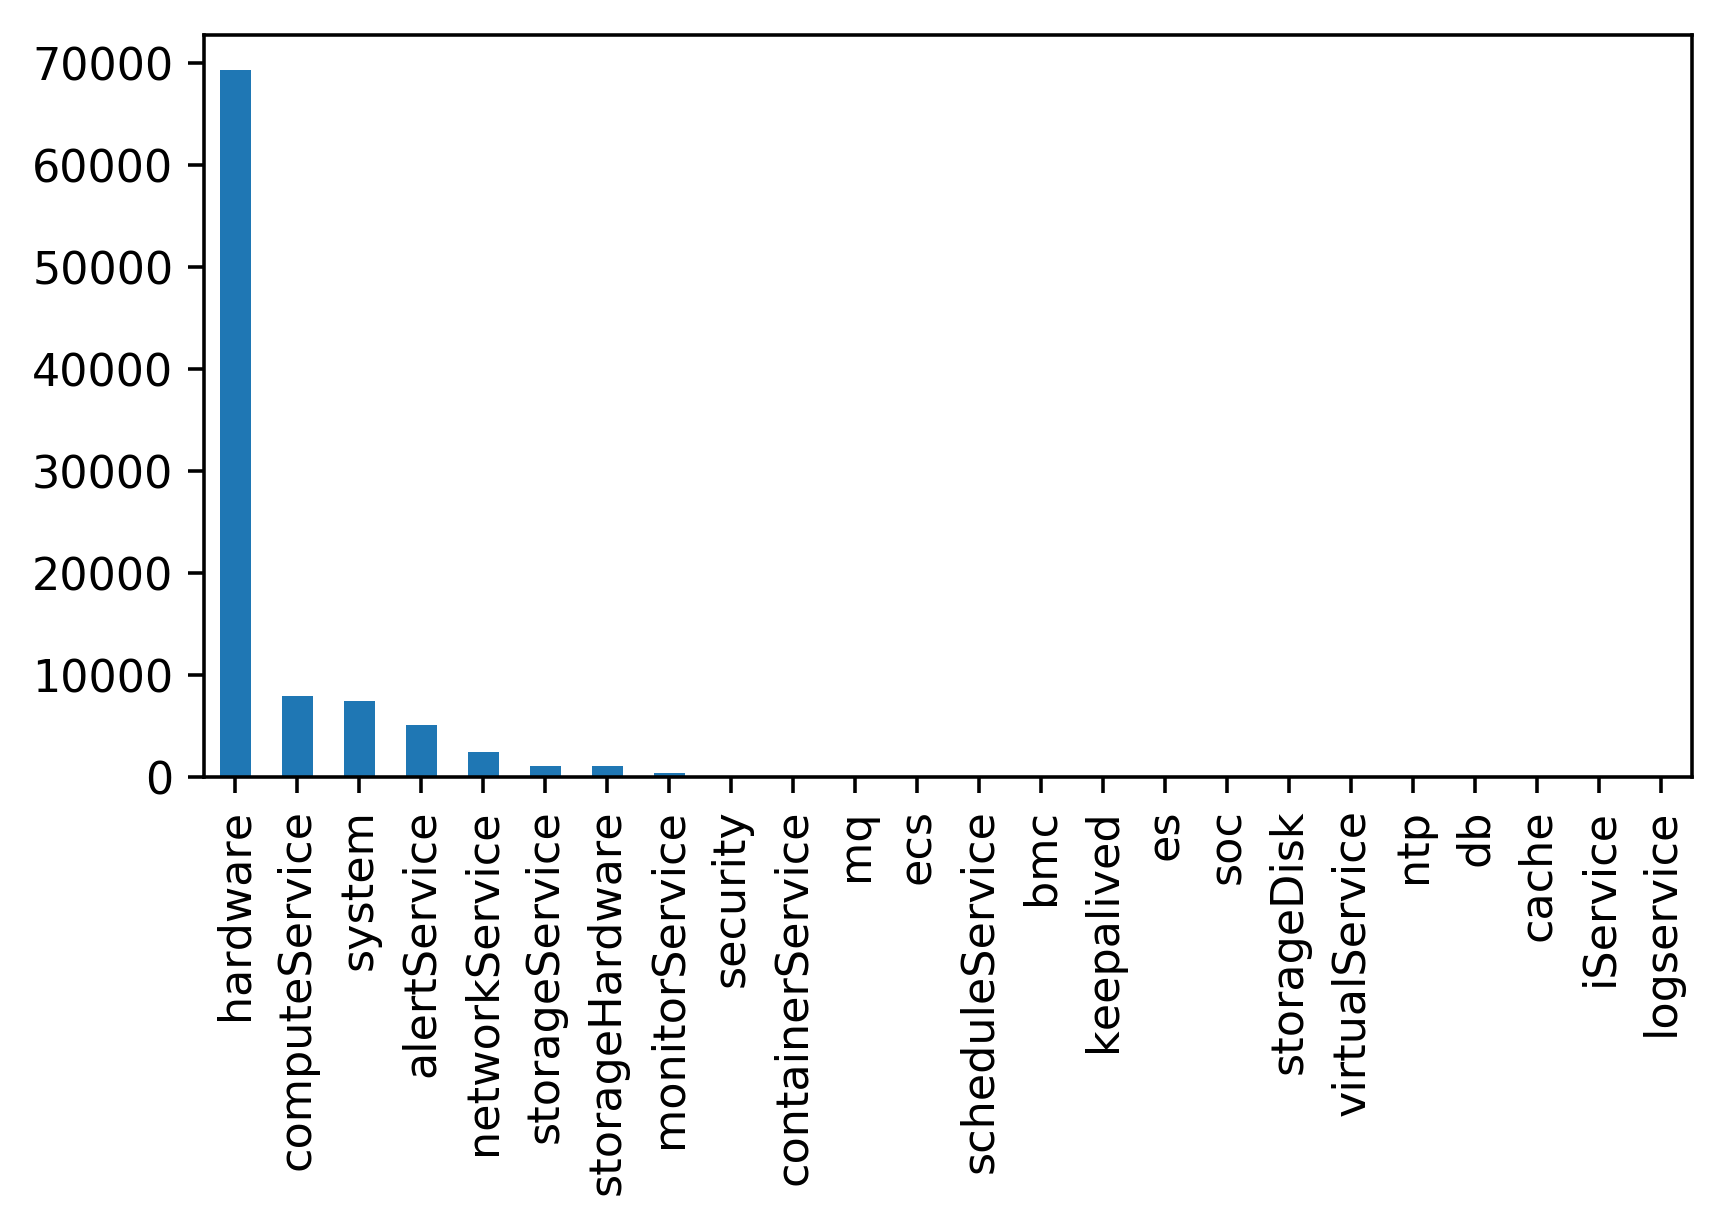

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=320)
plt.subplots_adjust(bottom=0.3)


data.serviceName.value_counts().plot(kind='bar') # .bar()
# class_counts.plot(kind='bar',  
#         figsize=(20, 16), fontsize=26).get_figure()

fig.savefig('serviceName.jpg')
# fig

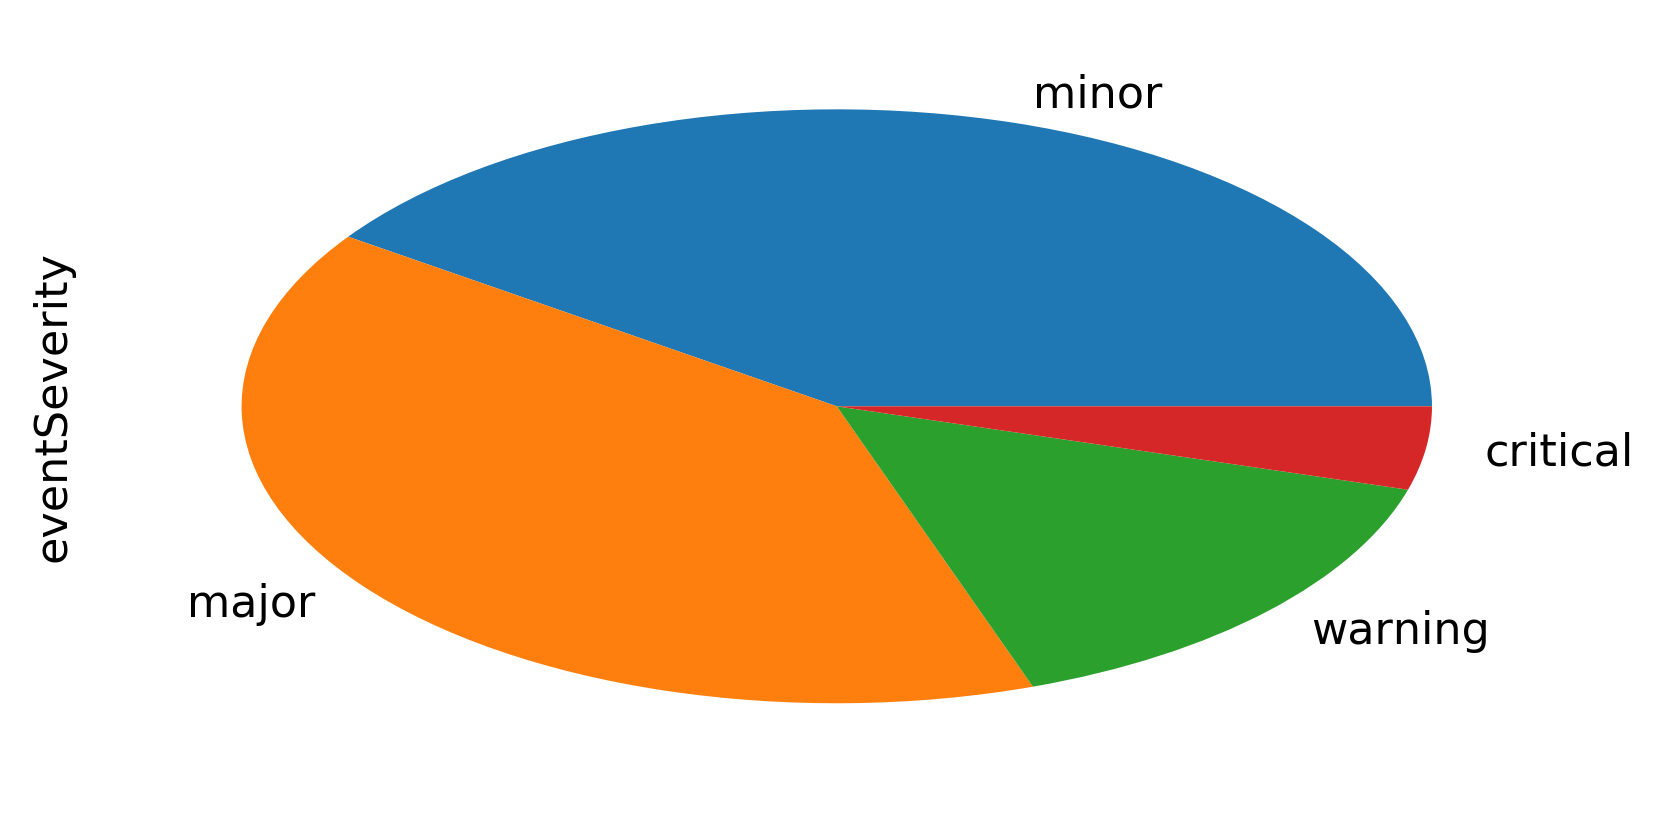

In [ ]:
fig = plt.figure(dpi=320)
plt.subplots_adjust(bottom=0.3)
data.eventSeverity.value_counts().plot(kind='pie') # .bar()


fig.savefig('eventSeverity.jpg')


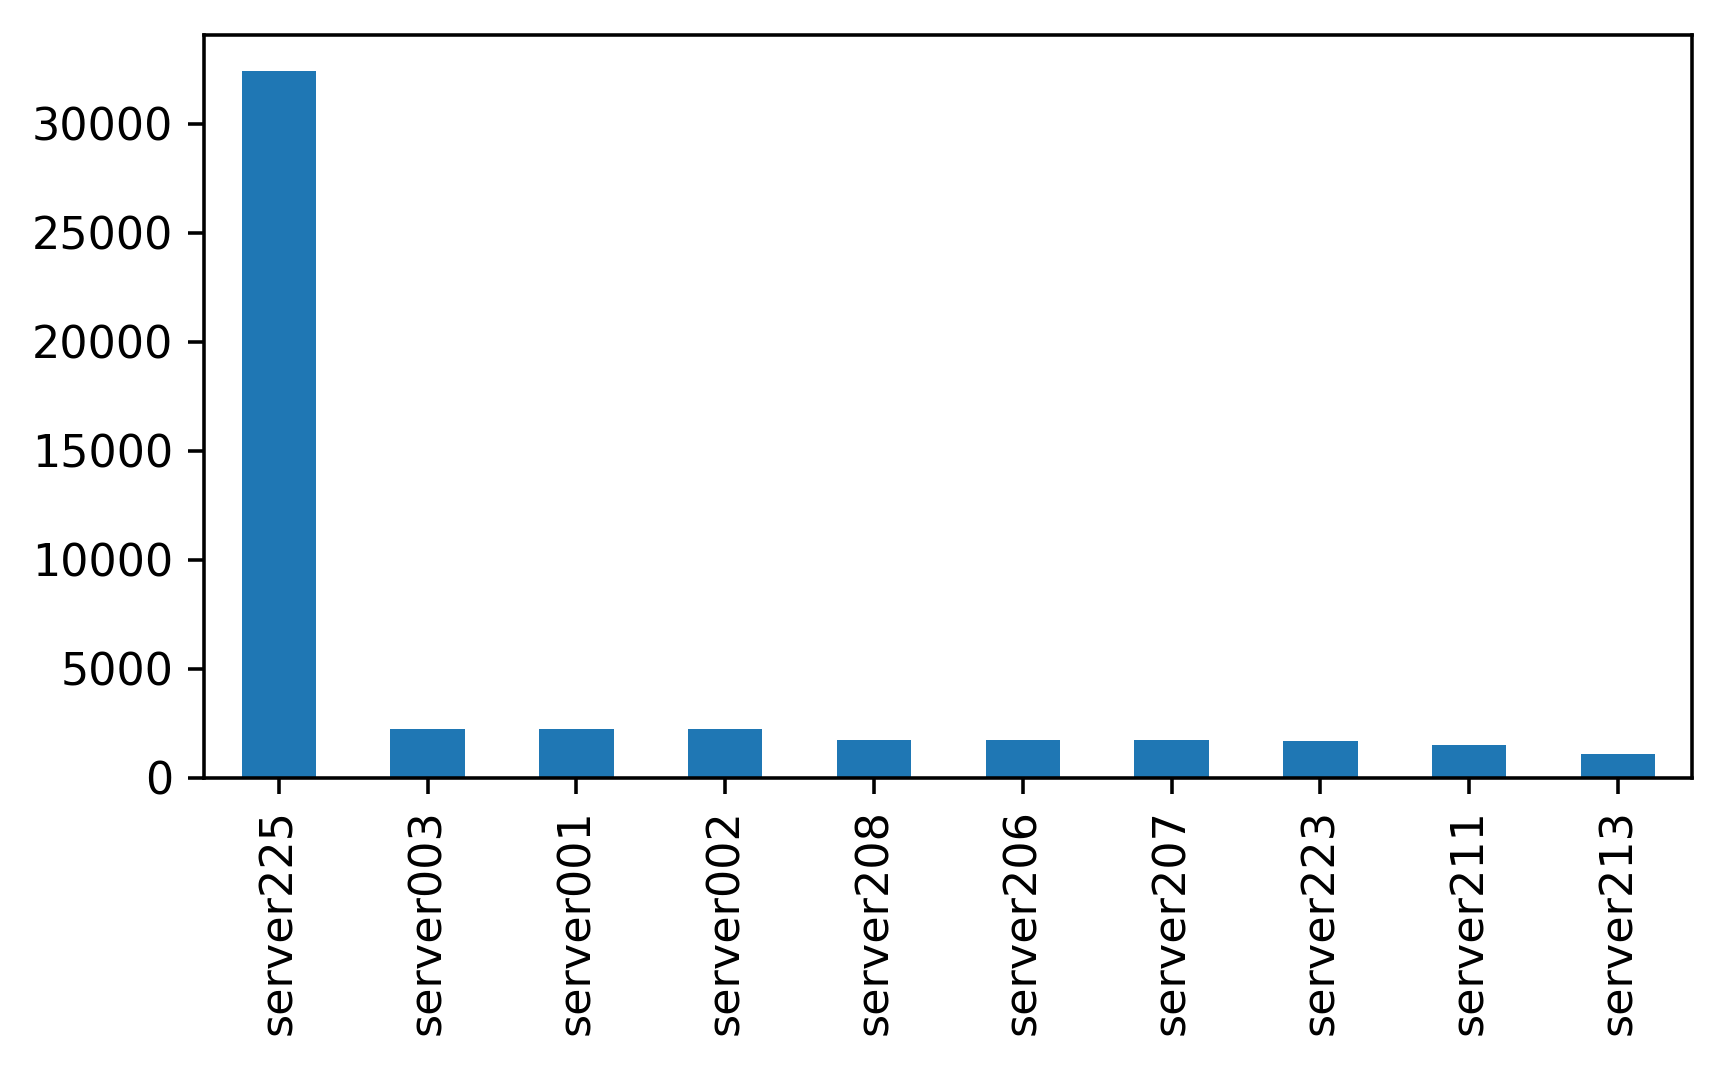

In [ ]:
fig = plt.figure(dpi=320)
plt.subplots_adjust(bottom=0.3)
data.eventHost.value_counts().head(10).plot(kind='bar')
fig.savefig('eventHost.jpg')


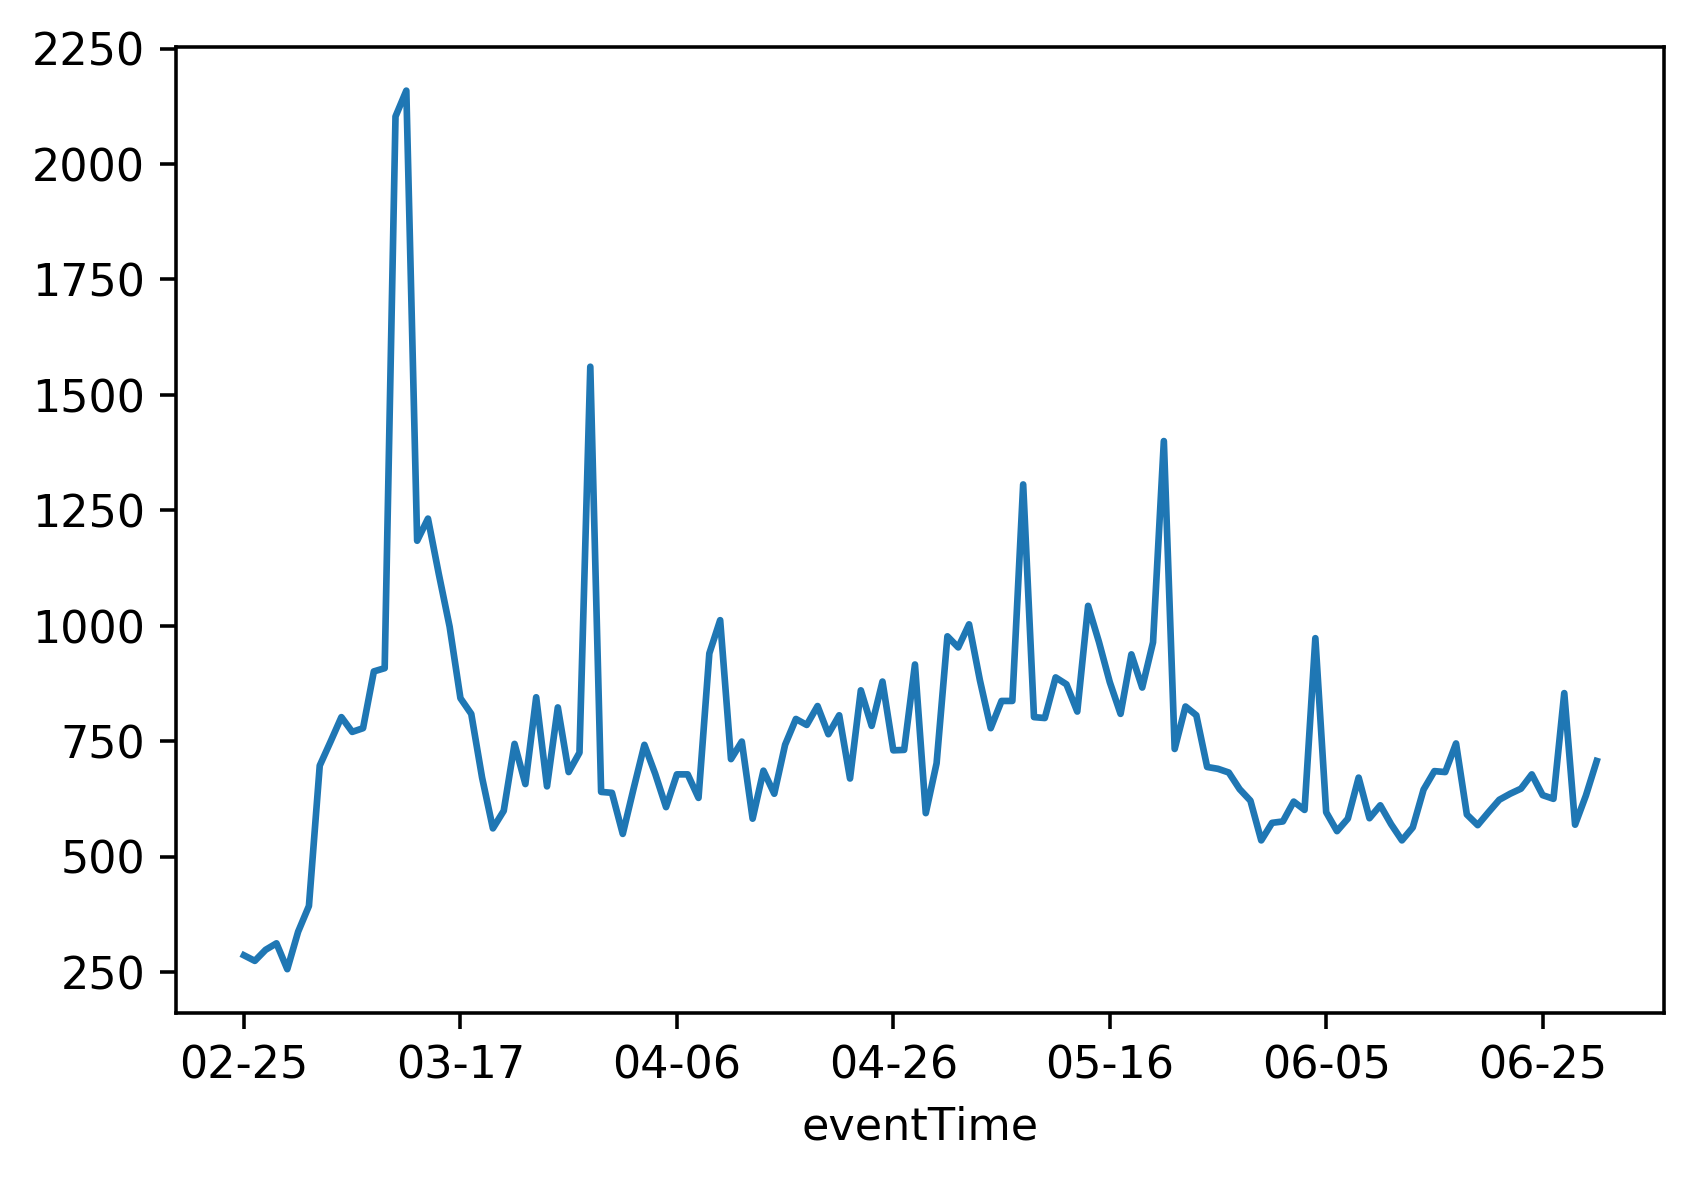

In [ ]:
import time
# print(time.localtime(time.time()time.time())
dd = data.eventTime.map(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(int(x // 1000))))
dd = data.eventTime.map(lambda x: time.strftime("%m-%d", time.localtime(int(x // 1000))))
fig = plt.figure(dpi=320)
dd.groupby(by=dd).count().plot()
# dd = pd.to_datetime(dd)
# dd.dt.day
fig.savefig('eventTime.jpg')




In [ ]:
data.shape

(95679, 8)